# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name:Lianming Shi

ID:A99097650

## Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
#environment
import gym
import os
import time
#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn

logging_interval = 100
animate_interval = logging_interval * 5
logdir='./DDPG/'

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [2]:
VISUALIZE = True
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
env_name = 'InvertedPendulum-v1'
#env_name = 'Pendulum-v0'
#env_name = 'HalfCheetah-v1' 

# wrap gym to save videos
env = gym.make(env_name)
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-05-15 12:04:51,900] Making new env: InvertedPendulum-v1
[2018-05-15 12:04:52,402] Clearing 2 monitor files from previous run (because force=True was provided)


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

## Pendulum-v0

#### reward system: 
reward=-(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) the lowest cost is -16.27 the highest cost is 0.0, the goal is to remain at zero angle (vertical), with the least rotational velocity, and the least effort.

theta range: [-pi,pi]

#### observation space:
 
state[0]: cos(theta). range:[-1.0, 1.0]

state[1]: sin(theta). range:[-1.0, 1.0]

state[2]: theta dot.  range:[-8.0, 8.0]

#### action space: 
only one action: joint effort .  range:[-2.0, 2.0]


#### when is the environment considered "solved": 
Pendulum-v0 does not have a specified reward threshold at which it's considered solved.


## HalfCheetah-v1

#### reward system:
Reward:  R(s,a)=V(s)-0.1·‖a‖.sum

V(s) is the speed of cheetah on x-axis


#### observation space:
- state[0]:  rootx     slider      position (m)
- state[1]:  rootz     slider      position (m)
- state[2]:  rooty     hinge       angle (rad)
- state[3]:  bthigh    hinge       angle (rad)
- state[4]:  bshin     hinge       angle (rad)
- state[5]:  bfoot     hinge       angle (rad)
- state[6]:  fthigh    hinge       angle (rad)
- state[7]:  fshin     hinge       angle (rad)
- state[8]:  ffoot     hinge       angle (rad)
- state[9]:  rootx     slider      velocity (m/s)
- state[10]:  rootz     slider      velocity (m/s)
- state[11]:  rooty     hinge       angular velocity (rad/s)
- state[12]:  bthigh    hinge       angular velocity (rad/s)
- state[13]:  bshin     hinge       angular velocity (rad/s)
- state[14]:  bfoot     hinge       angular velocity (rad/s)
- state[15]:  fthigh    hinge       angular velocity (rad/s)
- state[16]:  fshin     hinge       angular velocity (rad/s)
- state[17]:  ffoot     hinge       angular velocity (rad/s)

#### action space:
- action[0]:  bthigh    hinge       torque (N m)
- action[1]:  bshin     hinge       torque (N m)
- action[2]:  bfoot     hinge       torque (N m)
- action[3]:  fthigh    hinge       torque (N m)
- action[4]:  fshin     hinge       torque (N m)
- action[5]:  ffoot     hinge       torque (N m)

#### when is the environment considered "solved": 
HalfCheetah-v1 is considered "solved" when the agent obtains an average reward of at least 4800.0 over 100 consecutive episodes.

## InvertedPendulum-v1


#### reward system:
Reward increase by 1 for every step taken

#### observation space:
Observation[0]: pendulum Position.      Range:[-inf, inf]

Observation[1]: pendulum Velocity.      Range:[-inf, inf]

Observation[2]: pole Angle.             Range:[-inf, inf]

Observation[3]: pole Velocity At Tip.    Range:[-inf, inf]     

#### action space:
There are one continuous action apply to the pole. Range: [-3.0, 3.0]

#### when is the environment considered "solved": 

Inverted pendulum v1 is considered "solved" as getting average reward of 500.0 over 100 consecutive trials. 

### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [14]:
class NormalizeAction(gym.ActionWrapper):
    def action(self, action):
        action = (action + 1) / 2  
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        a
        ction = action * 2 - 1
        return actions


# DDPG

### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [15]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [16]:
from collections import deque
import random

class Replay(object):
    def __init__(self, maxlen = 60000):
        self.maxlen = maxlen
        self.data = deque(maxlen = self.maxlen)
        self.initialize(init_length=1000, envir=env)

    def initialize(self,init_length=1000, envir=env):
        s = envir.reset()
        for i in range (init_length):
            a = np.random.random(1)-np.random.random(1)
            #a = env.action_space.sample()
            s1, r, done, _ = env.step(a)            
            self.add([np.reshape(s,(1,obs_dim)), np.reshape(a,(1,act_dim)), r, done, np.reshape(s1,(1,obs_dim))])
                        
            if done:
                s=envir.reset()
            else: 
                s = s1  
                
         
    def add(self, ep):
        self.data.append(ep)

    def sample(self, nsamples):
        if nsamples > len(self.data):
            return random.sample(self.data, len(self.data))
        else:
            return random.sample(self.data, nsamples)

    def display(self):
        for x in self.data:
            print (x) 

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [17]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, mu=np.zeros(act_dim), sigma=0.05, theta=.25, dimension=1e-2, x0=None,num_steps=12000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dimension
        self.x0 = x0
        self.reset()

    def step(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [18]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class critic(nn.Module):

    def __init__(self, state_size, action_size,output_size = 1):
        super(critic, self).__init__()

        self.state_dim = state_size
        self.action_dim = action_size
        h1_dim = 300
        h2_dim = 300

        self.fc1 = nn.Linear(self.state_dim,h1_dim)
        
        #self.bn1 = nn.BatchNorm1d(h1_dim)
        
        self.fc2 = nn.Linear(h1_dim + self.action_dim,h2_dim)
        
        self.fc3 = nn.Linear(h2_dim,output_size)


    def forward(self, sa):
        state, action =sa
        #s1 = F.relu(self.bn1(self.fc1(state)))
        s1 = F.relu(self.fc1(state))

        x = torch.cat((s1,action),dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class actor(nn.Module):

    def __init__(self, input_size, output_size):
        super(actor, self).__init__()

        self.state_dim = input_size
        self.action_dim = output_size
        h1_dim = 400
        h2_dim = 400

        self.fc1 = nn.Linear(self.state_dim,h1_dim)
        #self.bn1 = nn.BatchNorm1d(h1_dim)

        self.fc2 = nn.Linear(h1_dim,h2_dim)
        #self.bn2 = nn.BatchNorm1d(h2_dim)

        self.fc3 = nn.Linear(h2_dim,self.action_dim)


    def forward(self, state):
        #x = F.relu(self.bn1(self.fc1(state)))
        #x = F.relu(self.bn2(self.fc2(x)))
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = F.tanh(self.fc3(x))

        return action
    

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [19]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())
        if use_cuda:
            self.actor.cuda()
            self.actor_target.cuda()
            self.critic.cuda()
            self.critic_target.cuda()
        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)

        # replay buffer 
        self.replayBuffer = Replay()

        
    def action(self, s, noise):
        obs = torch.from_numpy(s).unsqueeze(0)
        inp = Variable(obs,volatile=True).type(FloatTensor)

        self.actor.eval()
        a = self.actor(inp).data[0].cpu().numpy() 
        self.actor.train()

        if noise is not None:
            a = a + noise
        return a
    
    def train(self,training_data):
        # sample from Replay
        batch_s = np.vstack(training_data[:,0])
        batch_a = np.vstack(training_data[:,1])
        batch_s1 = np.vstack(training_data[:,4])
        batch_r = np.array(training_data[:,2]).astype("float")
        batch_done = np.array(training_data[:,3]).astype("float")
        
        s1 = Variable(torch.from_numpy(batch_s)).type(FloatTensor)
        a1 = Variable(torch.from_numpy(batch_a)).type(FloatTensor)
        r1 = Variable(torch.from_numpy(batch_r[:,None]),volatile = True).type(FloatTensor)
        s2 = Variable(torch.from_numpy(batch_s1), volatile = True).type(FloatTensor)
        d  = Variable(torch.from_numpy(1.0*batch_done)[:,None]).type(FloatTensor)

       
        a2 = self.actor_target.forward(s2)
        # ---------------------- optimize critic ----------------------

        next_val = self.critic_target((s2, a2)).detach()
        
        q_expected = r1 + self.gamma*next_val*(1.0-d)
        
        # y_pred = Q( s1, a1)
        q_predicted = self.critic((s1, a1))

        
        #print (y_predicted.volatile)
        #print (y_expected.volatile)

        # compute critic loss, and update the critic
        loss_critic = self.critic_loss(q_predicted, q_expected)
        self.optimizer_critic.zero_grad()
        #print (loss_critic.volatile)
        loss_critic.backward()
        self.optimizer_critic.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1)
        loss_actor = -1*self.critic.forward((s1, pred_a1))
        loss_actor = loss_actor.mean()
        #input()
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        #print (loss_actor.volatile)
        self.optimizer_actor.step()
        
        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [20]:
ddpg = DDPG(obs_dim = obs_dim, act_dim = act_dim)
print(ddpg.actor)
print(ddpg.critic)

actor(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
critic(
  (fc1): Linear(in_features=4, out_features=300, bias=True)
  (fc2): Linear(in_features=301, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [21]:
env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
#term_condition = -150 # Pendulum
term_condition = 500 # inverted Pendulum
#term_condition = 1500 # half cheetah



for itr in range(NUM_EPISODES):
    s=env.reset() # get initial state
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
    total_reward=0
    #actor_noise = OrnsteinUhlenbeckProcess(mu=np.zeros(act_dim))
    while True:
        ddpg.noise.reset()
        if animate_this_episode:
                env.render('rgb_array')
                time.sleep(0.05)
        a = ddpg.action(s, ddpg.noise.step())
        s1, r, done, _ = env.step(a)
        total_reward += r

        ddpg.replayBuffer.add([np.reshape(s,(1,obs_dim)), np.reshape(a,(1,act_dim)), r, done, np.reshape(s1,(1,obs_dim))])
        s = np.copy(s1)

        training_data = np.array(ddpg.replayBuffer.sample(BATCH_SIZE))
        ddpg.train(training_data)
        step_counter += 1

        if done:
            break
    if itr > 3 and avg_val > term_condition:
            break
    running_rewards_ddpg.append(total_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average value: 0.5 for episode: 0
Average value: 0.675 for episode: 1
Average value: 0.84125 for episode: 2
Average value: 0.9491875000000001 for episode: 3
Average value: 1.051728125 for episode: 4
Average value: 1.14914171875 for episode: 5
Average value: 1.2416846328125 for episode: 6
Average value: 1.329600401171875 for episode: 7
Average value: 1.413120381113281 for episode: 8
Average value: 1.4924643620576168 for episode: 9
Average value: 1.5678411439547357 for episode: 10
Average value: 1.6394490867569989 for episode: 11
Average value: 1.7074766324191488 for episode: 12
Average value: 1.8221028007981912 for episode: 13
Average value: 1.9309976607582815 for episode: 14
Average value: 2.084447777720367 for episode: 15
Average value: 2.7302253888343486 for episode: 16
Average value: 3.343714119392631 for episode: 17
Average value: 3.4265284134229996 for episode: 18
Average value: 3.45520199275185 for episode: 19
Average value: 3.432441893114257 for episode: 20
Average value: 3.4108

Average value: 2.445715877817917 for episode: 177
Average value: 2.423430083927021 for episode: 178
Average value: 2.4522585797306697 for episode: 179
Average value: 2.429645650744136 for episode: 180
Average value: 2.4081633682069294 for episode: 181
Average value: 2.387755199796583 for episode: 182
Average value: 2.368367439806754 for episode: 183
Average value: 2.399949067816416 for episode: 184
Average value: 2.379951614425595 for episode: 185
Average value: 2.3609540337043153 for episode: 186
Average value: 2.3929063320190993 for episode: 187
Average value: 2.3732610154181444 for episode: 188
Average value: 2.3545979646472373 for episode: 189
Average value: 2.386868066414875 for episode: 190
Average value: 2.3675246630941316 for episode: 191
Average value: 2.349148429939425 for episode: 192
Average value: 2.3816910084424534 for episode: 193
Average value: 2.3626064580203305 for episode: 194
Average value: 2.344476135119314 for episode: 195
Average value: 2.3772523283633484 for epi

Average value: 2.422112444437534 for episode: 344
Average value: 2.4010068222156575 for episode: 345
Average value: 2.4309564811048743 for episode: 346
Average value: 2.4594086570496305 for episode: 347
Average value: 2.436438224197149 for episode: 348
Average value: 2.4646163129872916 for episode: 349
Average value: 2.4413854973379268 for episode: 350
Average value: 2.46931622247103 for episode: 351
Average value: 2.4458504113474784 for episode: 352
Average value: 2.4235578907801045 for episode: 353
Average value: 2.402379996241099 for episode: 354
Average value: 2.432260996429044 for episode: 355
Average value: 2.410647946607592 for episode: 356
Average value: 2.440115549277212 for episode: 357
Average value: 2.4181097718133517 for episode: 358
Average value: 2.447204283222684 for episode: 359
Average value: 2.47484406906155 for episode: 360
Average value: 2.5011018656084723 for episode: 361
Average value: 2.5260467723280486 for episode: 362
Average value: 2.549744433711646 for episo

Average value: 2.4053977084232563 for episode: 519
Average value: 2.435127823002093 for episode: 520
Average value: 2.4133714318519885 for episode: 521
Average value: 2.4427028602593888 for episode: 522
Average value: 2.4205677172464193 for episode: 523
Average value: 2.3995393313840983 for episode: 524
Average value: 2.3795623648148934 for episode: 525
Average value: 2.360584246574149 for episode: 526
Average value: 2.3425550342454415 for episode: 527
Average value: 2.3254272825331697 for episode: 528
Average value: 2.3091559184065114 for episode: 529
Average value: 2.3436981224861855 for episode: 530
Average value: 2.376513216361876 for episode: 531
Average value: 2.3576875555437824 for episode: 532
Average value: 2.3398031777665933 for episode: 533
Average value: 2.3728130188782632 for episode: 534
Average value: 2.3541723679343503 for episode: 535
Average value: 2.3864637495376324 for episode: 536
Average value: 2.367140562060751 for episode: 537
Average value: 2.398783533957713 fo

Average value: 48.38338582016026 for episode: 682
Average value: 48.16421652915224 for episode: 683
Average value: 47.95600570269463 for episode: 684
Average value: 47.9082054175599 for episode: 685
Average value: 47.962795146681906 for episode: 686
Average value: 47.8646553893478 for episode: 687
Average value: 47.87142261988041 for episode: 688
Average value: 47.777851488886384 for episode: 689
Average value: 47.68895891444206 for episode: 690
Average value: 47.80451096871995 for episode: 691
Average value: 47.764285420283954 for episode: 692
Average value: 47.776071149269754 for episode: 693
Average value: 47.78726759180626 for episode: 694
Average value: 47.74790421221595 for episode: 695
Average value: 47.86050900160515 for episode: 696
Average value: 47.76748355152489 for episode: 697
Average value: 47.729109373948646 for episode: 698
Average value: 47.792653905251214 for episode: 699
Average value: 47.853021209988654 for episode: 700
Average value: 47.660370149489225 for episode

Average value: 54.921651656089836 for episode: 846
Average value: 55.37556907328534 for episode: 847
Average value: 56.456790619621074 for episode: 848
Average value: 57.58395108864002 for episode: 849
Average value: 58.504753534208014 for episode: 850
Average value: 58.87951585749761 for episode: 851
Average value: 61.93554006462273 for episode: 852
Average value: 62.48876306139159 for episode: 853
Average value: 62.81432490832201 for episode: 854
Average value: 62.923608662905906 for episode: 855
Average value: 62.827428229760606 for episode: 856
Average value: 62.88605681827258 for episode: 857
Average value: 62.99175397735895 for episode: 858
Average value: 63.792166278491 for episode: 859
Average value: 63.40255796456645 for episode: 860
Average value: 63.43243006633813 for episode: 861
Average value: 65.21080856302122 for episode: 862
Average value: 65.65026813487015 for episode: 863
Average value: 67.06775472812663 for episode: 864
Average value: 67.56436699172029 for episode: 8

Average value: 54.33079050720484 for episode: 1010
Average value: 54.61425098184459 for episode: 1011
Average value: 54.53353843275236 for episode: 1012
Average value: 54.50686151111474 for episode: 1013
Average value: 54.381518435559 for episode: 1014
Average value: 54.26244251378105 for episode: 1015
Average value: 54.199320388092 for episode: 1016
Average value: 54.38935436868739 for episode: 1017
Average value: 54.36988665025302 for episode: 1018
Average value: 54.15139231774037 for episode: 1019
Average value: 54.34382270185335 for episode: 1020
Average value: 54.12663156676068 for episode: 1021
Average value: 54.27029998842264 for episode: 1022
Average value: 54.106784989001504 for episode: 1023
Average value: 53.951445739551424 for episode: 1024
Average value: 54.25387345257385 for episode: 1025
Average value: 54.391179779945155 for episode: 1026
Average value: 54.0716207909479 for episode: 1027
Average value: 54.0180397514005 for episode: 1028
Average value: 53.86713776383047 f

Average value: 63.27151127079247 for episode: 1171
Average value: 63.25793570725285 for episode: 1172
Average value: 63.2950389218902 for episode: 1173
Average value: 63.330286975795694 for episode: 1174
Average value: 63.36377262700591 for episode: 1175
Average value: 63.09558399565561 for episode: 1176
Average value: 63.39080479587283 for episode: 1177
Average value: 63.571264556079186 for episode: 1178
Average value: 63.742701328275224 for episode: 1179
Average value: 64.25556626186146 for episode: 1180
Average value: 64.14278794876839 for episode: 1181
Average value: 64.18564855132996 for episode: 1182
Average value: 63.826366123763464 for episode: 1183
Average value: 63.73504781757529 for episode: 1184
Average value: 63.49829542669653 for episode: 1185
Average value: 63.523380655361706 for episode: 1186
Average value: 63.54721162259362 for episode: 1187
Average value: 63.56985104146394 for episode: 1188
Average value: 63.99135848939074 for episode: 1189
Average value: 64.091790564

Average value: 81.05488363173245 for episode: 1332
Average value: 81.20213945014582 for episode: 1333
Average value: 81.09203247763853 for episode: 1334
Average value: 81.28743085375659 for episode: 1335
Average value: 82.27305931106875 for episode: 1336
Average value: 82.2094063455153 for episode: 1337
Average value: 82.24893602823954 for episode: 1338
Average value: 82.28648922682757 for episode: 1339
Average value: 82.22216476548618 for episode: 1340
Average value: 83.16105652721187 for episode: 1341
Average value: 83.20300370085127 for episode: 1342
Average value: 83.5928535158087 for episode: 1343
Average value: 83.51321084001826 for episode: 1344
Average value: 83.53755029801735 for episode: 1345
Average value: 83.91067278311648 for episode: 1346
Average value: 83.76513914396065 for episode: 1347
Average value: 84.52688218676262 for episode: 1348
Average value: 85.55053807742449 for episode: 1349
Average value: 85.42301117355326 for episode: 1350
Average value: 85.9018606148756 f

Average value: 120.64549597851789 for episode: 1492
Average value: 117.763221179592 for episode: 1493
Average value: 115.2750601206124 for episode: 1494
Average value: 113.16130711458177 for episode: 1495
Average value: 111.40324175885269 for episode: 1496
Average value: 109.48307967091006 for episode: 1497
Average value: 107.75892568736455 for episode: 1498
Average value: 106.67097940299632 for episode: 1499
Average value: 106.1874304328465 for episode: 1500
Average value: 106.92805891120416 for episode: 1501
Average value: 108.53165596564395 for episode: 1502
Average value: 110.65507316736175 for episode: 1503
Average value: 155.12231950899366 for episode: 1504
Average value: 194.46620353354396 for episode: 1505
Average value: 188.24289335686674 for episode: 1506
Average value: 180.98074868902341 for episode: 1507
Average value: 173.88171125457222 for episode: 1508
Average value: 165.73762569184362 for episode: 1509
Average value: 159.4007444072514 for episode: 1510
Average value: 15

In [ ]:
#np.save('ddpg_invpendulum_reward.npy',running_rewards_ddpg)
#np.save('ddpg_invpendulum_step.npy',step_list_ddpg)

## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

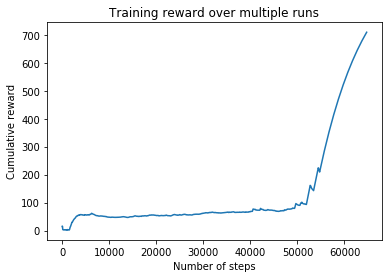

In [23]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

In [2]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

## ddpg inverted-pendulum

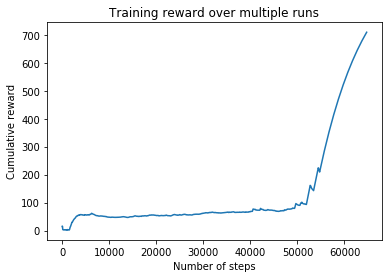

In [3]:
running_rewards_ddpg1=np.load('ddpg_invpendulum_reward.npy')
step_list_ddpg1=np.load('ddpg_invpendulum_step.npy')
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg1),20)
step_list_ddpg = np.array(step_list_ddpg1)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

## ddpg pendulum

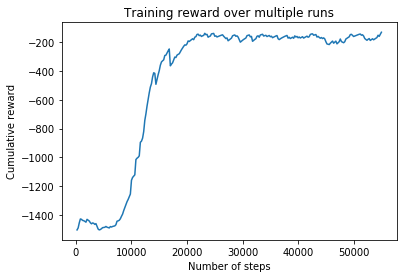

In [4]:
running_rewards_ddpg2=np.load('ddpg_pendulum_reward.npy')
step_list_ddpg2=np.load('ddpg_pendulum_step.npy')
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg2),20)
step_list_ddpg = np.array(step_list_ddpg2)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

## ddpg halfcheetah

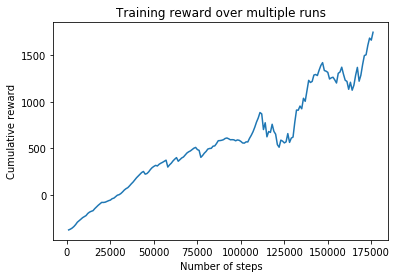

In [5]:
running_rewards_ddpg3=np.load('ddpg_cheetah_reward.npy')
step_list_ddpg3=np.load('ddpg_cheetah_step.npy')
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg3),20)
step_list_ddpg = np.array(step_list_ddpg3)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [5]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    def __init__(self, Dim_state, num_outputs, disct):
        super(mlp, self).__init__()
        self.disct = disct
        if self.disct == True:
            self.fc1 = nn.Linear(Dim_state, 50)
            self.fc2 = nn.Linear(50, 50)
            self.fc3 = nn.Linear(50, num_outputs)
        else:
            self.fc1 = nn.Linear(Dim_state, 50)
            self.fc2 = nn.Linear(50, 50)
            self.f3 = nn.Linear(50, num_outputs)   
            self.f3_ = nn.Linear(50, num_outputs)     


    def forward(self, x):
        if self.disct == True:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.softmax(x, dim=1)
        else: 
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            mu=self.f3(x)
            sigma=self.f3_(x)
            return [mu,sigma] 

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [6]:
def sample_action(logit, disct):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
    if disct == True:
        action_distribution=torch.distributions.Categorical(logit)
        action = action_distribution.sample()
        log_odds = action_distribution.log_prob(action)
    else : # continuous 
        action_distribution = torch.distributions.normal.Normal(logit[0],F.softplus(logit[1]))
        action = action_distribution.sample()
        log_odds = action_distribution.log_prob(action)
    return action, log_odds

Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [7]:
# calculated as "reward to go"
def rewardtogo(rewards, gamma =1):
    r2g = []
    acc_r = 0
    for r in reversed(rewards):
        acc_r = acc_r * gamma + r
        r2g.append(acc_r)
    return r2g[::-1]

def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object
    
    num_paths = len(paths)
    rew_cums = []
    log_odds = []

    
    for path in paths:
        # rew_cums should record return at each time step for each path
        rew_cums += rewardtogo(path['reward'])
        # log_odds should record log_odds obtained at each timestep of path
        log_odds += path['log_odds']
        # calculated as "reward to go" 

    # make log_odds, rew_cums each a vector
    rewards = np.array(rew_cums)
    log_odds = np.array(log_odds)
    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5) # create baseline
    # calculate policy loss and average over paths
    policy_loss = -rewards.dot(log_odds)/ num_paths
    
    # take optimizer step
    optimizer.zero_grad()
    policy_loss.sum().backward()
    optimizer.step() 
    
    

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [8]:
# Select Environment

#discrete environment:
env_name='CartPole-v0'

#continous environments:
#env_name='InvertedPendulum-v1'
#env_name = 'HalfCheetah-v1'


# Make the gym environment
env = gym.make(env_name)
visualize = True
animate=visualize
learning_rate = 1e-3

max_path_length=None
min_timesteps_per_batch=2000

# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./REINFORCE/'

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)
env._max_episodes_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Make network object (remember to pass in appropriate flags for the type of action space in use)
# net = mlp(*args)

net = mlp(Dim_state = obs_dim, num_outputs = act_dim, disct = discrete).type(FloatTensor)

# Make optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)


[2018-05-12 20:34:38,063] Making new env: CartPole-v0
[2018-05-12 20:34:38,202] Clearing 14 monitor files from previous run (because force=True was provided)


## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

[2018-05-12 20:34:43,734] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video000000.mp4


Average reward: 18.0


[2018-05-12 20:36:43,112] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video000500.mp4


[2018-05-12 20:36:57,851] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video001000.mp4


[2018-05-12 20:37:14,639] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video001500.mp4


[2018-05-12 20:37:31,748] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video002000.mp4


[2018-05-12 20:37:53,111] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video002500.mp4


[2018-05-12 20:38:25,121] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video003000.mp4


[2018-05-12 20:39:40,151] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video003500.mp4


Average reward: 182.94523081302052


[2018-05-12 20:41:17,726] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video004000.mp4


[2018-05-12 20:43:04,085] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video004500.mp4


Average reward: 194.68931715509262


[2018-05-12 20:44:46,023] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video005000.mp4


[2018-05-12 20:46:32,301] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video005500.mp4


Average reward: 197.4571976632323


[2018-05-12 20:48:19,248] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video006000.mp4


[2018-05-12 20:50:03,612] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video006500.mp4


[2018-05-12 20:51:45,304] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video007000.mp4


Average reward: 199.98494526446345


[2018-05-12 20:53:30,155] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video007500.mp4


[2018-05-12 20:55:13,030] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video008000.mp4


Average reward: 199.99138268186357


[2018-05-12 20:58:58,106] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video008500.mp4


[2018-05-12 21:00:47,847] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video009000.mp4


Average reward: 199.757053339971


[2018-05-12 21:02:36,847] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video009500.mp4


[2018-05-12 21:04:24,205] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video010000.mp4


Average reward: 199.9985616272001


[2018-05-12 21:06:13,928] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video010500.mp4


[2018-05-12 21:07:52,919] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video011000.mp4


Average reward: 195.81493228361245


[2018-05-12 21:09:32,587] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video011500.mp4


[2018-05-12 21:11:17,699] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video012000.mp4


[2018-05-12 21:13:01,279] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video012500.mp4


Average reward: 199.97522218429586


[2018-05-12 21:14:49,785] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video013000.mp4


[2018-05-12 21:16:38,708] Starting new video recorder writing to /datasets/home/04/004/l5shi/ece276_hw3/REINFORCE/openaigym.video.0.1950.video013500.mp4


[2018-05-12 21:17:10,023] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/04/004/l5shi/ece276_hw3/REINFORCE')


Text(0,0.5,'Average reward')

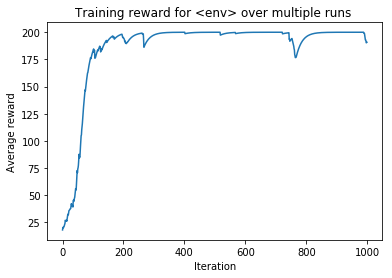

In [9]:
n_iter = 1000 
min_timesteps_per_batch = 2000  # sets the batch size for updating network
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0

for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()   
        animate_this_episode = (itr % animate_interval == 0) and visualize
        obs, acs, rews, log_odds = [], [], [], [] 
        obs.append(ob)

        while True: # loop for episode inside batch
            if animate_this_episode:
                env.render()
                time.sleep(0.05)
            # get parametrized policy distribution from net using current state ob
            net.eval()
            var_ob = Variable(torch.unsqueeze(FloatTensor(ob),0), requires_grad=False)
            distribution_parameters = net(var_ob)
            net.train()
            # sample action and get log-probability (log_odds) from distribution
            cuda_tensor_ac, log_odd= sample_action(logit = distribution_parameters , disct = discrete)
            ac = cuda_tensor_ac.data[0].cpu().numpy()
            # step environment, record reward, next state
            ob, rew, done, _ = env.step(ac)
            # append to obs, acs, rewards, log_odds
            obs.append(ob)
            acs.append(ac)
            rews.append(rew)
            log_odds.append(log_odd)
            
            # if done, restart episode till min_timesteps_per_batch is reached     
            steps += 1
            
            if done:
                episodes = episodes + 1
                break
                
        path = {"observation" : obs, 
                "reward" : np.array(rews), 
                "action" : (acs),
                "log_odds" : log_odds}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 

    update_policy(paths, net)  # use all complete episodes (a batch of timesteps) recorded in this itr to update net

    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    
    if avg_reward > 200:
        break
    
    total_steps += steps
    print(avg_reward,end='\r')
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % logging_interval == 0:
        print('Average reward: {}'.format(avg_reward))
   
      
env.close()
#np.save('reinforce_cheetah_reward.npy', avg_rewards)
#np.save('reinforce_cheetah_step.npy', step_list_reinforce)
plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

In [10]:
np.save('reinforce_cartpole_reward.npy', avg_rewards)
np.save('reinforce_cartpole_step.npy', step_list_reinforce)

Text(0,0.5,'Average reward')

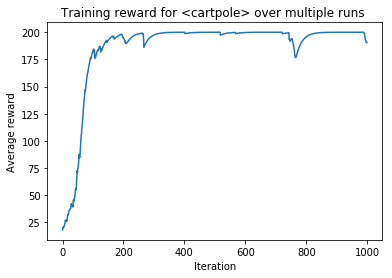

In [13]:
plt.plot(avg_rewards)
plt.title('Training reward for <cartpole> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


In [ ]:
 # import your DQN and format your average returns as defined above


# DQN and Reinforce

In [ ]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
batch_size = 1000
learning_rate = 0.01                   # learning rate
env = gym.make('CartPole-v0')   
#env = env.unwrapped
action_size = env.action_space.n  
state_size = env.observation_space.shape[0]   
hidden_size = 64
alpha_decay = 0.1


In [ ]:
class Net(nn.Module):
    def __init__(self,hidden_size,state_size, action_size):
        super(Net, self).__init__()
        nn.Module.__init__(self)
        self.dense1 = nn.Linear(state_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)
     #   self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate,weight_decay=alpha_decay)    
     #   self.loss_func = nn.MSELoss()  

    def forward(self, x):
        x = self.dense1(x)
        x = F.tanh(x)
        actions_value = self.out(x)
        return actions_value
    
class QNetwork(object):
    def __init__(self,learning_rate, state_size, action_size, hidden_size, alpha_decay):
        self.hidden_size=hidden_size
        self.state_size=state_size
        self.action_size=action_size
        self.alpha_decay=alpha_decay
        self.net = Net(self.hidden_size,self.state_size,self.action_size)
        self.LR = learning_rate    
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.LR) 
        self.loss_func = nn.MSELoss() 
        
        
    def learn(self, current_q_value, expected_q_values):
        self.optimizer.zero_grad()

        loss = self.loss_func(current_q_value, expected_q_values)
        loss.backward()
        
        for param in self.net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    

In [ ]:
class Replay():
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.  
    def __init__(self, max_size):
        self.memory_counter = 0    
        self.capacity = max_size
        self.memory = []
        self.gamma=0.99
        
    def initialize(self,init_length, envir=env):
        state = envir.reset()
        for i in range (init_length):
            action = LongTensor([[env.action_space.sample()]])
            next_state, reward, done, _ = envir.step(action.data[0][0].cpu().numpy())
            
            self.push((FloatTensor([state]),
                     action,  
                     FloatTensor([next_state]),
                     FloatTensor([reward]),done))
            if done:
                state=envir.reset()
            else: 
                state = next_state            
        
    def push(self, transition):
        self.memory.append(transition)
        self.memory_counter += 1

        if len(self.memory) > self.capacity:
            del self.memory[0]


    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def generate_minibatch(self, DQN, targetDQN, BATCH_SIZE):
        transitions = self.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat( batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        
        # current Q values are estimated by NN for all actions
        current_q_values = DQN.net.forward(batch_state).gather(1, batch_action)
        
        # expected Q values are estimated from actions which gives maximum Q value
        max_next_q_values= targetDQN.net.forward(batch_next_state).detach().max(1)[0]
         
        #if done:     y = reward
        #if not done: y = reward + gamma*Qmax
        choose=np.invert(np.array(batch_done))*max_next_q_values.data.cpu().numpy()
        
        expected_q_values = batch_reward + (self.gamma * Variable(FloatTensor(choose)))
        expected_q_values = FloatTensor(expected_q_values.data.cpu().numpy()[:,None]) 
        return  current_q_values,expected_q_values 
    
        # loss is measured from error between current and newly expected Q values
        #loss = F.mse_loss(current_q_values, expected_q_values)
        # backpropagation of loss to NN
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()  

In [ ]:
DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)

targetDQN.net.load_state_dict(DQN.net.state_dict())
#targetDQN.net.dense1.weight=DQN.net.dense1.weight

# set targetDQN weights to DQN weights
# targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)

## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = Replay(max_size=10000)
replay.initialize(init_length=1000, envir=env)
if use_cuda:
    DQN.net.cuda()
    targetDQN.net.cuda()

In [ ]:
# Runtime parameters
num_episodes = 1000            # max number of episodes to learn from
gamma = 0.99                   # future reward discount
max_steps = 500                # cut off simulation after this many steps
# Exploration parameters
min_epsilon = 0.01             # minimum exploration probability
decay_rate = 5/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)
learn_step_counter=0
avg_reward = 0
avg_rewards=[]

for ep in range(0, num_episodes):
    paths=[]
    steps=0
    while True:
        total_reward=0
        # --> start episode 
        state = env.reset()
        epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
        rews=[]
        while True:

            # explore/exploit and get action using DQN
            if random.random() > epsilon:
                action = DQN.net.forward(Variable(FloatTensor([state]),volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)

            else:
                action = LongTensor([[random.randrange(2)]])
            next_state, reward, done, _ = env.step(action.data[0][0].cpu().numpy())

            total_reward=total_reward+reward
            # perform action and record new_state, action, reward
            # populate Replay experience buffer
            replay.push((FloatTensor([state]),action,FloatTensor([next_state]),FloatTensor([reward]),done))

            state = next_state
            rews.append(reward)
            steps+=1
            if done:
                #print(ep,   round(np.mean(returns[ep-99:ep]),0),end='\r')
                break
        path={'reward':np.array(rews)}
        paths.append(path)
        if steps > 2000:
            break
    # I modified the output of the generate_minibatch so that I can directly use these two q-values to 
    # calculate loss and do optimization 
    current_q_value, expected_q_values = replay.generate_minibatch(DQN, targetDQN, batch_size)
    DQN.learn(current_q_value,expected_q_values)
    returns[ep] = total_reward
    # set targetDQN weights to DQN weights
    # update DQN (run one epoch of training per episode with generated minibatch of states and qvalues)
    targetDQN.net.load_state_dict(DQN.net.state_dict())
    if ep==0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    total_steps+=steps
    avg_rewards.append(avg_reward)
    step_list_DQN.append(total_steps)

    if ep % 100 == 0:
        print('Average reward: {}'.format(avg_reward))



In [ ]:
plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

In [ ]:
#np.save('dqn.npy', avg_rewards)

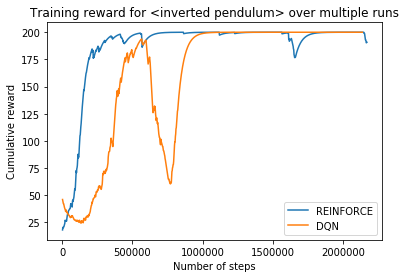

In [3]:

running_rewards_DQN=np.load('DQN_reward.npy')
step_list_DQN=np.load('DQN_step.npy')

step_list_reinforce=np.load('reinforce_cartpole_step.npy')

avg_rewards=np.load('reinforce_cartpole_reward.npy')
plt.plot(step_list_reinforce, avg_rewards) 
plt.plot(step_list_DQN, running_rewards_DQN)
plt.title('Training reward for <inverted pendulum> over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
#plt.legend(['DDPG', 'REINFORCE']) 
plt.legend(['REINFORCE','DQN'])

# DDPG and Reinforce

## Half Cheetah

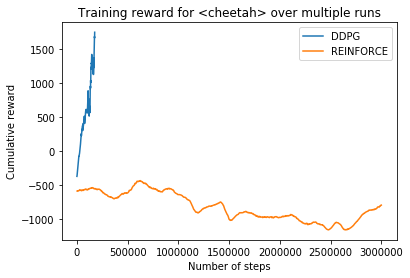

In [6]:
avg_rewards=np.load('reinforce_cheetah_reward.npy')
step_list_reinforce=np.load('reinforce_cheetah_step.npy')

plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg3),20)
plt.plot(step_list_ddpg3, out) 
plt.plot(step_list_reinforce, avg_rewards)
#plt.plot(step_list_DQN, out)
plt.title('Training reward for <cheetah> over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) 
#plt.legend(['DQN', 'REINFORCE'])


plt.show()


## Inverted Pendulum

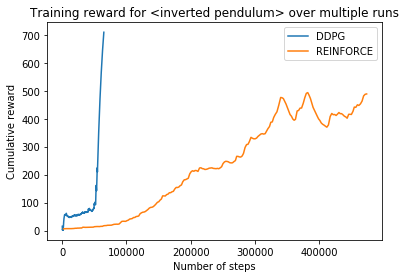

In [6]:
plt.figure()

avg_rewards=np.load('reinforce_invpendulum_reward.npy')
step_list_reinforce=np.load('reinforce_invpendulum_step.npy')


out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg1),20)
plt.plot(step_list_ddpg1, out) 
plt.plot(step_list_reinforce, avg_rewards)
#plt.plot(step_list_DQN, out)
plt.title('Training reward for <inverted pendulum> over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) 
#plt.legend(['DQN', 'REINFORCE'])


plt.show()